In [ ]:
import os, re, io, json, requests, zipfile, nltk
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Part 1: Analyze the network**
The questions in this part are based on *Lecture 5*.

Present an analysis/description of the network of bands/artists using tools from Lecture 5. Imagine that you have been tasked with presenting the important facts about the network to an audience who knows about network science, but doesn't know about this particular network.


*   It's OK to also use basic concepts like degree distributions (even though they're from week 4) in your analysis. That way you can make the analysis a standalone, coherent thing.
*   I would like you to include concepts like centrality and assortativity in your analysis.
*   Use a network backbone in your analysis.
*   In addition to standard distribution plots (e.g. degree distributions, etc), your analysis should also include at least one network visualization (but it doesn't have to display the entire network, you can also visualize a network backbone).
*   Note: As I write above, an important part of the exercise consists is selecting the right elements of the lecture to create a meaningful analysis. So don't solve this part by going exhaustive and just calculating everything you can think of in one massive analysis. Try to focus on using what you've learned to characterize the network.












In [ ]:
# ForceAtlas2 visualization of the giant connected component (undirected)
# Node size ∝ degree, node color ∝ word_count

import networkx as nx
import matplotlib.pyplot as plt

# --- 0) START FROM YOUR DIRECTED PERFORMER GRAPH ---
# G should be your directed DiGraph with 'word_count' node attribute.
# If you saved it before:
G = nx.read_gexf("rock_performers_full.gexf")

# --- 1) Undirected + Giant Connected Component ---
UG = G.to_undirected()
# remove isolates (optional, keeps plot clean)
UG.remove_nodes_from(list(nx.isolates(UG)))
# keep only the largest connected component
if UG.number_of_nodes() == 0:
    raise ValueError("Undirected graph has no nodes after removing isolates.")
largest_cc = max(nx.connected_components(UG), key=len)
UG = UG.subgraph(largest_cc).copy()

# --- 2) Visual encodings ---
degrees = dict(UG.degree())
node_sizes   = [max(3, degrees[n]) * 3 for n in UG.nodes()]  # scale factor → adjust
word_counts  = [UG.nodes[n].get("word_count", 0) for n in UG.nodes()]

# --- 3) Layout: ForceAtlas2 via fa2 ---
try:
    from fa2 import ForceAtlas2
except ImportError as e:
    raise ImportError(
        "ForceAtlas2 not found. Install with: pip install fa2\n"
        "Or upgrade NetworkX (>=3.4) and use nx.forceatlas2_layout."
    ) from e

forceatlas2 = ForceAtlas2(
    # Behavior
    outboundAttractionDistribution=True,  # hubs get more space
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    # Performance
    jitterTolerance=1.0,      # higher → faster, less precise
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=2.0,         # spread vs compact (try 1.0–8.0)
    strongGravityMode=False,
    gravity=1.0,              # pull to center (try 0.5–3.0)
    verbose=False
)

pos = forceatlas2.forceatlas2_networkx_layout(UG, pos=None, iterations=500)

# --- 4) Plot ---
plt.figure(figsize=(14, 10), facecolor="white")

nodes = nx.draw_networkx_nodes(
    UG, pos,
    node_size=node_sizes,
    node_color=word_counts,
    cmap=plt.cm.viridis,   # sequential colormap; try 'plasma', 'magma', 'inferno'
    alpha=0.9
)
nx.draw_networkx_edges(
    UG, pos,
    edge_color="black",
    alpha=0.25,
    width=0.3
)

cbar = plt.colorbar(nodes)
cbar.set_label("Page length (word_count)", fontsize=12)

plt.title("Rock performers (ForceAtlas2)\nSize ∝ degree, Color ∝ word_count",
          fontsize=14, color="black")
plt.axis("off")
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'rock_performers_full.gexf'

**Part 2: Genres and communities and plotting**
The questions below are based on *Lecture 7, part 2.*

*   Write about genres and modularity.
*   Detect the communities, discuss the value of modularity in comparison to the genres.
*   Calculate the matrix *D* and discuss your findings.
*   Plot the communities and comment on your results.








Now that we have the genres, let's use them - and see how community-like the community is, if we consider the genres to be community labels.


*Exercise*: Use the concept of modularity to explore how _community-like_ the genres are.
>
> * Explain the concept of modularity in your own words.
> * Work from the undirected version of the network, keeping only the nodes for which you have genre information.
> * Now create your own partition of the network into genres.
>      * **Each node is simply characterized by the *first genre* in its list of genres**.
>      * Each community is the group of nodes that share the same genre.
>      * That's all you need, now calculate the modularity of this division of the network into genres.
>      * **Note**: Modularity is described in the _Network Science_ book, section 9.4.. Thus, use **equation 9.12** in the book to calculate the modularity $M$ of the partition described above. Are the genres good communities?
> * Spoiling your findings a little bit, an issue is the following: Almost all artists have the genre `rock` as their first genre in the list, so by definition the network won't have very high modularity.
>      * What happens to the modularity if you grab the first genre *that's not `rock`* as the genre-assignment for all nodes that have more than one genre?
>      * What happens to the modularity if you use a random genre from the list genre as the node-lable for those nodes with more than one genre listed?
> * Discuss your findings.

<div class="alert alert-block alert-info">
Overall, it's OK to use an LLM to help with the code here. But do write your own explanation of modularity, and do try to implement a modularity on your own from eq 9.12 in the book.
</div>

In [3]:
url = "https://github.com/ahp9/social_graphs_02805_ass_2/archive/refs/heads/main.zip"
r = requests.get(url)
r.raise_for_status()
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

DATA_DIR = "social_graphs_02805_ass_2-main/performers"

In [4]:
WORD_RE = re.compile(r"\w+")
LINK_RE = re.compile(r"\[\[([^\]|#]+)\]")
INFOBOX_NAMES = (
    "Infobox musical artist",
    "Infobox musical artist2",
    "Infobox musical artist/Person",
    "Infobox person",
)

def file_to_title(fname): return fname.replace(".txt", "").replace("_", " ")
def normalize(title): return re.sub(r"[^a-z0-9]+", "", title.lower())

In [5]:
def extract_infobox(text):
    start_pat = r"\{\{\s*(?:" + "|".join(map(re.escape, INFOBOX_NAMES)) + r")\b"
    m = re.search(start_pat, text, flags=re.IGNORECASE)
    if not m: return None
    i = m.start(); j = i; depth = 0
    while j < len(text) - 1:
        two = text[j:j+2]
        if two == "{{": depth += 1; j += 2; continue
        if two == "}}": depth -= 1; j += 2
        if depth == 0: return text[i:j]
        j += 1
    return None

def split_top_level_params(infobox):
    first_bar = infobox.find("|", infobox.find("{{") + 2)
    if first_bar == -1: return {}
    body = infobox[first_bar:]
    params, buf, depth, i, L = {}, [], 0, 0, len(body)

    def flush_field(s):
        s = s.lstrip("|").strip()
        if "=" in s:
            k, v = s.split("=", 1)
            params[k.strip().casefold()] = v.strip()

    while i < L:
        two = body[i:i+2]
        if two == "{{": depth += 1; buf.append(two); i += 2; continue
        if two == "}}": depth = max(0, depth - 1); buf.append(two); i += 2; continue
        if body[i:i+2] == "\n|" and depth == 0:
            flush_field("".join(buf)); buf = []; i += 2; continue
        buf.append(body[i]); i += 1
    flush_field("".join(buf))
    return params

def extract_genre_block_from_infobox(infobox_text):
    params = split_top_level_params(infobox_text)
    return params.get("genre", "")

LIST_WRAPPERS = ("hlist", "flatlist", "ubl", "unbulleted list", "plainlist", "plain list")

def clean_genre_text(s):
    if not s: return ""
    s = re.sub(r"<!--.*?-->", "", s, flags=re.DOTALL)
    s = re.sub(r"<br\s*/?>", ",", s)
    s = re.sub(r"<[^>]+>", "", s)
    s = re.sub(r"\{\{\s*(?:" + "|".join(LIST_WRAPPERS) + r")\s*\|", "", s)
    s = s.replace("{{", "").replace("}}", "")
    s = re.sub(r"^\s*\*+\s*", "", s, flags=re.MULTILINE)
    s = s.replace("\n*", "\n")
    return s

def extract_genres(genre_block):
    s = clean_genre_text(genre_block)
    s = re.sub(r"cite\s+web[\s\S]*?(?=(\[\[|$))", "", s)
    s = re.sub(r"\b(?:url|title|publisher|access-date|work|last|first)\s*=\s*[^|}\n]*", "", s)
    link_matches = re.findall(r"\[\[([^\]]+)\]\]", s)
    genres = []
    for match in link_matches:
        parts = match.split("|")
        genre = parts[-1].strip()
        if genre and not any(x in genre for x in ("http", "cite", "url", "access-date")):
            genres.append(genre)
    out, seen = [], set()
    for g in genres:
        g2 = re.sub(r"\s+", " ", g).strip()
        key = g2.casefold()
        if key not in seen:
            seen.add(key); out.append(g2)
    return out

def canonicalize_genre(g):
    s = g.strip().replace("’", "'").replace("&amp;", "&")
    s = re.sub(r"\s+", " ", s).strip().casefold()
    s = re.sub(r"\brock\s*(?:'n'|’n’|n’|’n|n'|&|and)\s*roll\b", "rock and roll", s)
    s = re.sub(r"\bhip[-\s]?hop\b", "hip hop", s)
    s = re.sub(r"\brhythm and blues\b", "r&b", s)
    return s.strip()

In [6]:
files = [f for f in os.listdir(DATA_DIR) if f.endswith(".txt")]
performers = [file_to_title(f) for f in files]
norm2canon = {normalize(t): t for t in performers}

graph = nx.DiGraph()
graph.add_nodes_from(performers)

for fname in files:
    src = file_to_title(fname)
    path = os.path.join(DATA_DIR, fname)
    with open(path, "r", encoding="utf-8") as fh:
        text = fh.read()
    graph.nodes[src]["text"] = text

    infobox = extract_infobox(text)
    if infobox:
        genre_block = extract_genre_block_from_infobox(infobox)
        genres = [canonicalize_genre(g) for g in extract_genres(genre_block)]
        if genres:
            graph.nodes[src]["genres"] = list(set(genres))

    # find outgoing links
    unique_targets = set()
    for raw in LINK_RE.findall(text):
        tgt_norm = normalize(raw)
        if tgt_norm in norm2canon:
            dst = norm2canon[tgt_norm]
            if dst != src:
                unique_targets.add(dst)
    for dst in unique_targets:
        graph.add_edge(src, dst)

graph = graph.to_undirected()
print(f"Graph: {graph.number_of_nodes()} nodes, {graph.number_of_edges()} edges")


Graph: 488 nodes, 5585 edges


Equation 9.12
$$
M = \sum_{c=1}^{n_c} \bigg[\frac{L_c}{L} - \bigg( \frac{k_c}{2L}\bigg)^2 \bigg]
$$

In [12]:
# only keep nodes with graph info
graph_genre = graph.subgraph([n for n in graph.nodes if 'genre' in graph.nodes[n]])

# parationed by the first genre
partition = {}
for node, data in graph_genre.nodes(data=True):
    genres = data.get('genres', [])
    if genres:
        partition[node] = genres[0]

# group genres
genre_groups = defaultdict(list)
for node, genre in partition.items():
    genre_groups[genre].append(node)

# Modularity (equation )
L = graph_genre.number_of_edges() # total number of links
M = 0

for genre, nodes in genre_groups.items():
  subgraph = graph_genre.subgraph(nodes)
  L_c = subgraph.number_of_edges() # number of links in that community
  k_c = sum(dict(graph_genre.degree(nodes)).values()) # number of degrees in that community
  print(f"{genre:25s}  Lc={L_c:<5d}  kc={k_c:<5d}  term={(L_c / L) - (k_c / (2 * L))**2:.5f}")
  M += (L_c / L) - ((k_c / (2 * L)) ** 2)

print(f"Modularity (Eq. 9.12) = {M:.4f}")

Modularity (Eq. 9.12) = 0.0000


# ------------------------

In [ ]:
def report_genre_stats_from_graph(G, out_png="top15_genre_hist.png"):
    """
    Compute and plot genre statistics directly from the network graph.
    Expects each node to have a 'genres' attribute (list of genres).
    """
    # collect all genre lists
    genre_lists = [d["genres"] for _, d in G.nodes(data=True) if d.get("genres")]

    if not genre_lists:
        print("No genres found in graph.")
        return

    # basic stats
    n_nodes_with_genres = len(genre_lists)
    avg_genres_per_node = sum(len(v) for v in genre_lists) / n_nodes_with_genres
    distinct_genres = set(g for genres in genre_lists for g in genres)
    n_distinct = len(distinct_genres)

    # count artists per genre
    genre_counts = Counter(g for genres in genre_lists for g in set(genres))
    top15 = genre_counts.most_common(15)

    # print summary
    print(f"Number of artists with genres: {n_nodes_with_genres}")
    print(f"Average genres per artist: {avg_genres_per_node:.2f}")
    print(f"Distinct genres: {n_distinct}")
    print("\nTop 15 genres (by artist count):")
    for g, c in top15:
        print(f"  {g}: {c}")

    # plot histogram
    if top15:
        labels = [g for g, _ in top15]
        counts = [c for _, c in top15]
        labels_rev, counts_rev = labels[::-1], counts[::-1]

        plt.figure(figsize=(10, 6))
        plt.barh(labels_rev, counts_rev)
        plt.xlabel("Artist count")
        plt.title("Top 15 Genres (by artist count)")
        for i, v in enumerate(counts_rev):
            plt.text(v, i, f" {v}", va="center")
        plt.tight_layout()
        plt.savefig(out_png, dpi=150)
        print(f"\nSaved histogram to {out_png}")


Number of artists with genres: 424
Average genres per artist: 4.20
Distinct genres: 250

Top 15 genres (by artist count):
  alternative rock: 135
  hard rock: 135
  pop rock: 94
  rock: 62
  alternative metal: 59
  blues rock: 50
  heavy metal: 47
  post-grunge: 44
  allmusic: 39
  pop: 35
  indie rock: 35
  soft rock: 34
  progressive rock: 34
  new wave: 32
  art rock: 29

Saved histogram to top15_genre_hist.png


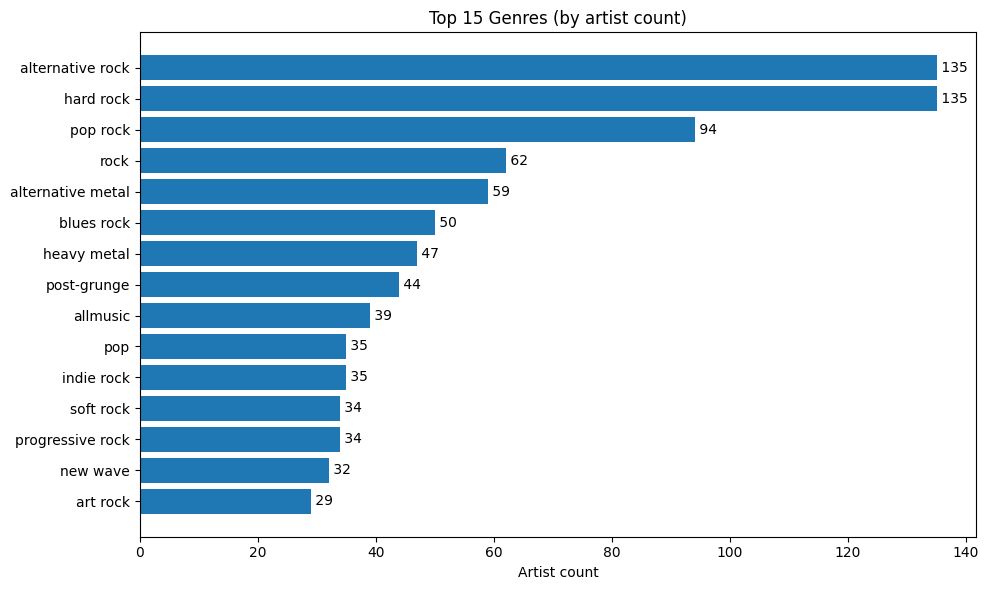

In [ ]:
report_genre_stats_from_graph(graph)

**Part 3: TF-IDF to understand genres and communities**
The questions below are based on *Lecture 7, part 2, 4, 5, 6 (and a little bit on part 3).*


*   Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.
*   Calculate and visualize TF-IDF for the genres and communities.
*   Use the matrix *D* (Lecture 7, part 2) to dicusss the difference between the word-clouds between genres and communities.



**Part 4: Sentiment of the artists and communities**
The questions below are based on *Lecture 8*

*   Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.
*   Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?





I would have run if I could to create a graph

In [ ]:
labmt_url = "https://raw.githubusercontent.com/ahp9/social_graphs_02805_ass_2/main/Data_Set_S1.txt"
labmt = pd.read_csv(labmt_url, sep="\t", skiprows=3)
word_to_scores = labmt.set_index("word").to_dict(orient="index")

In [ ]:
def calculate_sentiment(tokens):
    """
    Calculate average sentiment for a list of tokens based on LabMT word list.
    """
    tokens = [t.lower() for t in tokens]

    sentiment_score = 0
    for token in tokens:
        if token in word_to_scores:
            sentiment_score += word_to_scores[token]['happiness_average']
        else:
            sentiment_score += 0

    return sentiment_score

In [ ]:
for node in graph.nodes:
    text = graph.nodes[node].get('text', '')
    tokens = nltk.word_tokenize(text.lower())
    sentiment = calculate_sentiment(tokens)
    graph.nodes[node]['sentiment'] = sentiment

sentiments = [graph.nodes[n]['sentiment'] for n in graph.nodes if graph.nodes[n]['sentiment'] is not None]

mean_sent = np.mean(sentiments)
median_sent = np.median(sentiments)
variance_sent = np.var(sentiments)
q25 = np.percentile(sentiments, 25)
q75 = np.percentile(sentiments, 75)

print(f"Mean sentiment: {mean_sent}")
print(f"Median sentiment: {median_sent}")
print(f"Variance sentiment: {variance_sent}")
print(f"25th percentile sentiment: {q25}")
print(f"75th percentile sentiment: {q75}")

Mean sentiment: 34871.14684426258
Median sentiment: 29263.71999999982
Variance sentiment: 483042284.5322286
25th percentile sentiment: 19087.767499999773
75th percentile sentiment: 44748.48500000083


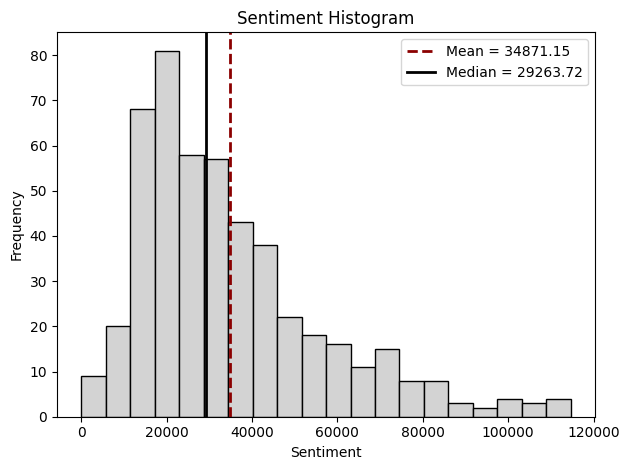

In [ ]:
fig, ax = plt.subplots()
ax.hist(sentiments, bins=20, color="lightgray", edgecolor="black")

# mean and median lines
ax.axvline(mean_sent, color='darkred', linestyle='--', linewidth=2, label=f"Mean = {mean_sent:.2f}")
ax.axvline(median_sent, color='black', linestyle='-', linewidth=2, label=f"Median = {median_sent:.2f}")

# labels
ax.set_xlabel("Sentiment")
ax.set_ylabel("Frequency")
ax.set_title("Sentiment Histogram")

ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
sotred_pages = sorted(graph.nodes, key=lambda x: graph.nodes[x]['sentiment'], reverse=True)

happiest_pages = sotred_pages[:10]
saddest_pages = sotred_pages[-10:]

print("Happiest pages:")
for page in happiest_pages:
    print(f"- {page}")

print("\nSaddest pages:")
for page in saddest_pages:
    print(f"- {page}")

Happiest pages:
- Bob Dylan
- Paul McCartney
- Queen (band)
- The Beach Boys
- The Rolling Stones
- Guns N' Roses
- The Beatles
- U2
- Elvis Presley
- David Bowie

Saddest pages:
- John Mayall & the Bluesbreakers
- Parliament (band)
- The Boxtones
- Manfred Mann Chapter Three
- The B-52's
- Jet (Australian band)
- Dallas Green (musician)
- Poison (American band)
- Van Zant (band)
- Dr. Hook & the Medicine Show
